<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy as sp; from scipy.io import wavfile; from scipy import signal
from scipy.signal import windows, freqz
import pydub
from pydub import AudioSegment
import statsmodels.tsa.stattools

The sampling rate of the audio files.

In [27]:
sr = 44100
NN = int(2.5*sr)

In [4]:
NN

110250

Little function used to write to audio files.

In [5]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# Get Data

In [6]:
df_a = pd.read_pickle("./acoustic_df.pkl")

In [7]:
E = np.array(df_a['E'].dropna())[0:NN]; Em = np.array(df_a['E_mute'].dropna())[0:NN]; 
A = np.array(df_a['A'].dropna())[0:NN]; Am = np.array(df_a['A_mute'].dropna())[0:NN]; 
D = np.array(df_a['D'].dropna())[0:NN]; Dm = np.array(df_a['D_mute'].dropna())[0:NN]; 
G = np.array(df_a['G'].dropna())[0:NN]; Gm = np.array(df_a['G_mute'].dropna())[0:NN]; 
B = np.array(df_a['B'].dropna())[0:NN]; Bm = np.array(df_a['B_mute'].dropna())[0:NN]; 
Eh = np.array(df_a['Eh'].dropna())[0:NN]; Ehm = np.array(df_a['Eh_mute'].dropna())[0:NN]; 

# Tapering

Apply a few filters to the time series of the form

$$L[X_t] = \sum_{u=-\infty}^\infty g_u X_{t-u} $$

In [8]:
def remove_mean(arr):
    return np.mean(arr), arr-np.mean(arr)

_, E_d = remove_mean(E)
_, Em_d = remove_mean(Em)
_, A_d = remove_mean(A)
_, Am_d = remove_mean(Am)
_, D_d = remove_mean(D)
_, Dm_d = remove_mean(Dm)
_, G_d = remove_mean(G)
_, Gm_d = remove_mean(Gm)
_, B_d = remove_mean(B)
_, Bm_d = remove_mean(Bm)
_, Eh_d = remove_mean(Eh)
_, Ehm_d = remove_mean(Ehm)

## Hanning Taper

In [9]:
def hanning_taper(arr):
    taper = signal.hann(len(arr))
    taper = taper/(np.linalg.norm(taper))
    
    return arr*taper

In [10]:
def get_hanning_taper(arr):
    taper = signal.hann(len(arr))
    taper = taper/(np.linalg.norm(taper))
    return taper

In [11]:
E_han = hanning_taper(E_d)
Em_han = hanning_taper(Em_d)
hanning_tap = get_hanning_taper(E_d)
tt = np.linspace(0, NN/sr, len(E_han))

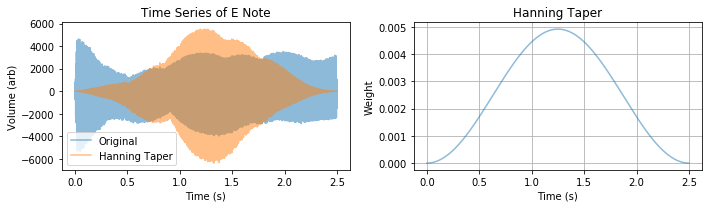

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(tt, E_d, alpha=0.5, label='Original')
ax[0].plot(tt, hanning_taper(E_d)*np.sqrt(NN), alpha=0.5, label='Hanning Taper')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Volume (arb)')
ax[0].legend()
ax[0].set_title('Time Series of E Note')

ax[1].plot(tt, hanning_tap, alpha=0.5)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Weight')
ax[1].grid()
ax[1].set_title('Hanning Taper')

fig.tight_layout()
plt.savefig('plots/tapering/hanning_example.png', dpi=200)

In [13]:
f_E, Pxx_den_E = signal.periodogram(E_d, sr)
f_E_han, Pxx_den_E_han = signal.periodogram(E_han, sr); Pxx_den_E_han*=NN

f_Em, Pxx_den_Em = signal.periodogram(Em_d, sr)
f_Em_han, Pxx_den_Em_han = signal.periodogram(Em_han, sr); Pxx_den_Em_han*=NN

### Plot Periodogram

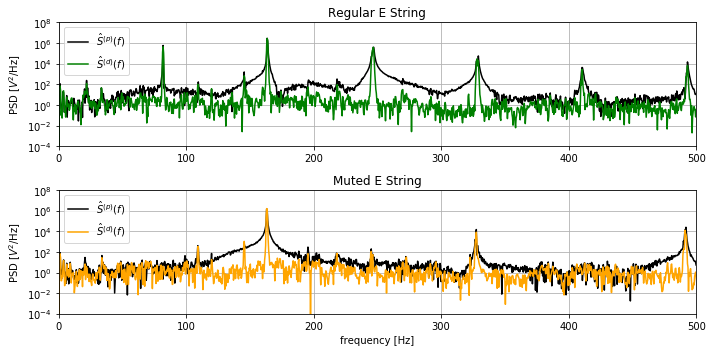

In [14]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

ax[0].semilogy(f_E, Pxx_den_E, label='$\hat{S}^{(p)}(f)$', c='k')
ax[0].semilogy(f_E_han, Pxx_den_E_han, label='$\hat{S}^{(d)}(f)$', c='green')

ax[1].semilogy(f_Em, Pxx_den_Em, label='$\hat{S}^{(p)}(f)$', c='k')
ax[1].semilogy(f_Em_han, Pxx_den_Em_han, label='$\hat{S}^{(d)}(f)$', c='orange')

ax[1].set_xlabel('frequency [Hz]')
[a.set_ylabel('PSD [$V^2$/Hz]') for a in ax.ravel()]
[a.set_xlim(0,500) for a in ax.ravel()]
[a.set_ylim(10**-4, 10**8) for a in ax.ravel()]
[a.legend() for a in ax.ravel()]
[a.grid() for a in ax.ravel()]


ax[0].set_title('Regular E String')
ax[1].set_title('Muted E String')


fig.tight_layout()
plt.savefig('plots/tapering/E_hanning_taper.png', dpi=200)
plt.show()

Conclusion: Hanning Window more effective when spectral range is more varying (more peaks).

In [15]:
def Fejer(f):
    return (1/(NN*sr)) * ((np.sin(NN*np.pi*f/sr))/(np.sin(np.pi*f/sr)))**2

In [56]:
ff_fej = np.linspace(0,1/2,1000000)*sr
Fejer_kernel = Fejer(ff_fej)

Hanning_kernel = (1/sr)*np.abs(np.fft.fft(hanning_tap))**2
ff_han = np.fft.fftfreq(len(Hanning_kernel))*sr

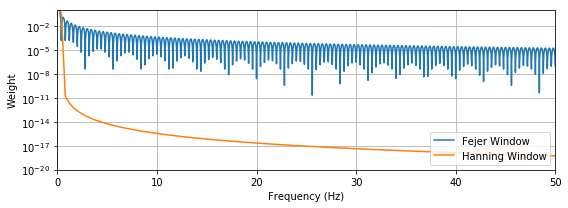

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(ff_fej, Fejer_kernel, label='Fejer Window')
ax.semilogy(ff_han, Hanning_kernel, label='Hanning Window')
ax.set_xlim(0,50)
ax.set_ylim(10**-20, 1)
ax.grid()
ax.legend(loc='lower right')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Weight')

fig.tight_layout()
plt.savefig('plots/tapering/han_vs_fej.png', dpi=200)

## DPSS Taper

In [93]:
# Requires Interpolation because DPSS algorithm cannot give large sequence values
def DPSS_taper(arr, NW = 1):
    x = np.arange(0,10001)
    y = windows.dpss(10001, NW)
    f = sp.interpolate.interp1d(x, y)
    
    x_new = np.arange(0,10000,10000/len(arr))
    taper = f(x_new)
    
    return arr*taper/(np.linalg.norm(taper))

def norm_taper(arr): # see pg 207 1/sqrt(N) correspondance
    return arr/sqrt(NN)
    
def DPSS(arr, NW = 1):
    x = np.arange(0,10001)
    y = windows.dpss(10001, NW)
    f = sp.interpolate.interp1d(x, y)
    
    x_new = np.arange(0,10000,10000/len(arr))
    
    return f(x_new)/(np.linalg.norm(f(x_new)))

In [94]:
def Fejer(f):
    return np.piecewise(f, [f==0 , f > 0],
                        [lambda f: NN/sr,
                         lambda f: (1/(NN*sr))*(np.sin(NN*np.pi*f*(1/sr))**2)/(np.sin(np.pi*f*(1/sr))**2)])

In [95]:
NW1 = 10; NW2 = 30; NW3 = 50; NW4 = 100
E_dpss1 = DPSS_taper(E_d, NW=NW1)
E_dpss2 = DPSS_taper(E_d, NW=NW2)
E_dpss3 = DPSS_taper(E_d, NW=NW3)
E_dpss4 = DPSS_taper(E_d, NW=NW4)

In [96]:
f_E, Pxx_den_E = signal.periodogram(E_d, sr)
f_E_dpss1, Pxx_den_E_dpss1 = signal.periodogram(E_dpss1, sr); Pxx_den_E_dpss1*=NN
f_E_dpss2, Pxx_den_E_dpss2 = signal.periodogram(E_dpss2, sr); Pxx_den_E_dpss2*=NN
f_E_dpss3, Pxx_den_E_dpss3 = signal.periodogram(E_dpss3, sr); Pxx_den_E_dpss3*=NN
f_E_dpss4, Pxx_den_E_dpss4 = signal.periodogram(E_dpss4, sr); Pxx_den_E_dpss4*=NN

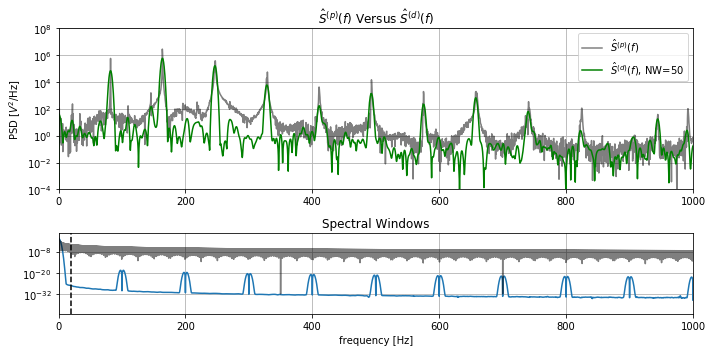

In [99]:
NWI = 50

fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E, label='$\hat{S}^{(p)}(f)$', c='k', alpha=0.5)
ax.semilogy(f_E_dpss4, Pxx_den_E_dpss4,label='$\hat{S}^{(d)}(f)$, NW='+str(NWI), c='green')


DPSS_kernel = (1/sr)*np.abs(np.fft.fft(DPSS(E_d, NW=NWI)))**2; DPSS_kernel = np.fft.fftshift(DPSS_kernel)
ff_DPSS = np.fft.fftfreq(len(DPSS(E_d, NW=NWI)))*sr; ff_DPSS = np.fft.fftshift(ff_DPSS)

ff_fej = np.linspace(0,1/2,1000000)*sr
Fejer_kernel = Fejer(ff_fej)

axm.semilogy(ff_DPSS, DPSS_kernel, label='$\mathcal{H}(f)$')
axm.semilogy(ff_fej, Fejer_kernel, color='k', alpha=0.5, label='$\mathcal{F}(f)$')
axm.set_xlim(0,1000)
#axm.set_ylim(10**-15, 1)
axm.grid()
axm.set_xlabel('frequency [Hz]')
axm.axvline(NWI*sr/NN, c='k', ls='--')


ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8) 

ax.legend() 
ax.grid()

ax.set_title('$\hat{S}^{(p)}(f)$ Versus $\hat{S}^{(d)}(f)$')
axm.set_title('$\mathcal{H}(f)$')
axm.set_title('Spectral Windows')

fig.tight_layout()
plt.savefig('test_plot.png', dpi=300)
plt.show()

In [22]:
a = 4.56677

### Create an Animation

In [126]:
def animate(i, note, notename, FF):
    if i==0:
        global f_note; global Pxx_den_note
        f_note, Pxx_den_note = signal.periodogram(note, sr)
    
    NW = 0.4*i+1
    
    #Compute tapered time series
    note_dpss = DPSS_taper(note, NW=NW)
    f_note_dpss, Pxx_den_note_dpss = signal.periodogram(note_dpss, sr); Pxx_den_note_dpss*=NN
    ## ^^ multiply by NN bc scaling already taken into account by h_t factors (comapre 206c to 196c)
    
    # Compute frequency reponse of taper
    DPSS_kernel = (1/sr)*np.abs(np.fft.fft(DPSS(E_d, NW=NW)))**2; DPSS_kernel = np.fft.fftshift(DPSS_kernel)
    ff_DPSS = np.fft.fftfreq(len(DPSS(E_d, NW=NWI)))*sr; ff_DPSS = np.fft.fftshift(ff_DPSS)

    ff_fej = np.linspace(0,1/2,1000000)*sr
    Fejer_kernel = Fejer(ff_fej)
    
    ax.clear()
    axm.clear()
    
    ax.semilogy(f_note, Pxx_den_note, label='$\hat{S}^{(p)}(f)$', c='k', alpha=0.5)
    ax.semilogy(f_note_dpss, Pxx_den_note_dpss, label='$\hat{S}^{(d)}(f)$, NW='+str(round(NW,2)), c='green')
    
    axm.semilogy(ff_DPSS, DPSS_kernel, label='$\mathcal{H}(f)$')
    axm.semilogy(ff_fej, Fejer_kernel, color='k', alpha=0.5, label='$\mathcal{F}(f)$')
    
    axm.set_xlim(0,50)
    axm.set_ylim(10**-20, 1)
    axm.grid()
    axm.set_xlabel('frequency [Hz]')
    axm.set_ylabel('Value')
    axm.axvline(NW*sr/len(note), c='k', ls='--')

    ax.set_ylabel('PSD [$V^2$/Hz]')
    ax.set_xlim(0,min(FF*10, max(f_note_dpss)))
    ax.set_ylim(10**-4, 10**8) 
    ax.legend() 
    ax.grid()

    ax.set_title('Spectral Estimators for '+notename + ' String')
    axm.set_title('Spectral Windows')
    axm.legend(loc='lower right')
    fig.tight_layout()

In [127]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))
interval = 0.5#in seconds     
ani = animation.FuncAnimation(fig,animate,60,interval=interval*1e+3,blit=False,
                             fargs=(E_d, 'E', 82.4))
ani.save('plots/tapering/E_DPSS.mp4', fps=10)
plt.close()

In [128]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))
interval = 0.5#in seconds     
ani = animation.FuncAnimation(fig,animate,60,interval=interval*1e+3,blit=False,
                             fargs=(A_d, 'A', 82.4))
ani.save('plots/tapering/A_DPSS.mp4', fps=10)
plt.close()

In [129]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))
interval = 0.5#in seconds     
ani = animation.FuncAnimation(fig,animate,60,interval=interval*1e+3,blit=False,
                             fargs=(D_d, 'D', 82.4))
ani.save('plots/tapering/D_DPSS.mp4', fps=10)
plt.close()

In [130]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))
interval = 0.5#in seconds     
ani = animation.FuncAnimation(fig,animate,60,interval=interval*1e+3,blit=False,
                             fargs=(G_d, 'G', 82.4))
ani.save('plots/tapering/G_DPSS.mp4', fps=10)
plt.close()

In [131]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))
interval = 0.5#in seconds     
ani = animation.FuncAnimation(fig,animate,60,interval=interval*1e+3,blit=False,
                             fargs=(B_d, 'B', 82.4))
ani.save('plots/tapering/B_DPSS.mp4', fps=10)
plt.close()

In [132]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))
interval = 0.5#in seconds     
ani = animation.FuncAnimation(fig,animate,60,interval=interval*1e+3,blit=False,
                             fargs=(Eh_d, 'Eh', 82.4))
ani.save('plots/tapering/Eh_DPSS.mp4', fps=21)
plt.close()

# Smoothing

Computing the smoothed spectrum is a little bit complicated because (237a) is defined as a sum over negative values but numpys Fourier transform library only goes as $\sum_{j=0}^N [] e^{-i 2 \pi kj/N}$. Thus we use

$$\sum_{j=-K}^K [] e^{-i 2 \pi kj/N} = \sum_{j=0}^K f(j) e^{-i 2 \pi k j/N} +  \sum_{j=0}^K ([0] + f(-j)) e^{i 2 \pi k j/N} $$

Where [0] is an array of with one element of a zero. This is a combination of a Fourier transform and an inverse Fourier transform.

In [181]:
def get_autocov(arr):
    s = statsmodels.tsa.stattools.acovf(arr, unbiased=False)
    return np.concatenate((np.flip(s[1::]), s))

def get_periodogram(acvs, window):
    
    N= len(acvs)
    
    # Positive Portion
    win_1 = window[N-1::] 
    acvs_1 = acvs[0::]
    FFT_1 = np.fft.fft(win_1*acvs_1, N)
    
    # Negative Portion
    win_2 = np.concatenate((np.array([0]), window[N::]))
    acvs_2 = np.concatenate((np.array([0]), acvs[1::]))
    FFT_2 = len(win_2)*np.fft.ifft(win_2*acvs_2, N) #see definition scipy for why we multiply by N and take inverse
    
    # Frequency Stuff
    ff_lw = np.fft.fftfreq(N, 1/sr)
    
    FFT = FFT_1+FFT_2
    
    return ff_lw[0:int(N/2)], FFT[0:int(N/2)]/sr

Window Functions

In [185]:
def get_parzen(m, N):
    return np.concatenate((np.zeros(N-m), sp.signal.parzen(2*m-1), np.zeros(N-m)))

def get_classical(N):
    return np.zeros(2*N-1)+1

Compute the ACVS of the sequences and use this to get the smoothed periodograms using (237a).

In [186]:
st_D_norm = statsmodels.tsa.stattools.acovf(E_d)
st_D_han = statsmodels.tsa.stattools.acovf(E_han)

ff_lw, S_lw = get_periodogram(st_D_norm,  get_parzen(int(len(E_d)/5), len(E_d)))
ff_d_lw, S_d_lw = get_periodogram(st_D_han,  get_parzen(int(len(E_han)/5), len(E_han))); S_d_lw*=NN

f_Ed, Pxx_den_Ed = signal.periodogram(E_d, sr)

Plot

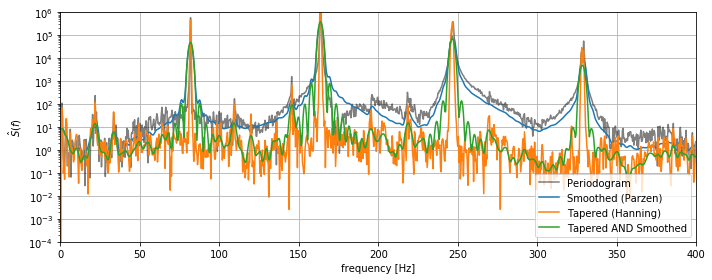

In [151]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

ax.semilogy(f_Ed, Pxx_den_Ed,label='Periodogram', c='k', alpha=0.5)
ax.semilogy(ff_lw, np.abs(S_lw), label='Smoothed (Parzen)')
ax.semilogy(f_E_han, Pxx_den_E_han, label='Tapered (Hanning)')
ax.semilogy(ff_d_lw, np.abs(S_d_lw), label='Tapered AND Smoothed')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel(r'$\hat{S}(f)$')
ax.set_xlim(0,400)
ax.set_ylim(10**-4, 10**6) 
ax.legend(loc='lower right') 
ax.grid()

fig.tight_layout()
plt.savefig('plots/smoothing/smooth_taper_ex.png', dpi=200)
plt.show()

Animation of changing the smoothing parameter $m$ and seeing real time how the smoothing changes.

In [194]:
def animate(i, arr, acvs):
    ff_lw, S_lw = get_periodogram(acvs,  get_parzen(int(len(arr)/((i+1))), len(arr)))   
    ff, Pxx_den = signal.periodogram(arr, sr)
    
    ax.clear()
    
    ax.semilogy(ff, Pxx_den, label='$\hat{S}^{(p)}(f)$', c='k', alpha=0.5)
    ax.semilogy(ff_lw, np.abs(S_lw), label=r'$\hat{S}^{(lw)}(f)$ where m/N = 1/'+str(i+1), c='green')

    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel(r'Spectral Estimator [V^2/Hz]')
    ax.set_xlim(0,1000)
    ax.set_ylim(10**-4, 10**6) 
    ax.legend() 
    ax.grid()

In [202]:
st_p = statsmodels.tsa.stattools.acovf(E_d, unbiased=False)
fig, ax = plt.subplots(1,1, figsize=(8,3))
interval = 5 #in seconds     
aniE = animation.FuncAnimation(fig,animate,50,interval=interval*1e+3,blit=False,
                             fargs=(E_d, st_p))
aniE.save('plots/smoothing/E_Parzen.mp4', fps=20, dpi=150)
plt.close()

In [203]:
st_d = statsmodels.tsa.stattools.acovf(np.sqrt(NN)*E_han, unbiased=False)
fig, ax = plt.subplots(1,1, figsize=(8,3))
interval = 5 #in seconds     
aniE = animation.FuncAnimation(fig,animate,50,interval=interval*1e+3,blit=False,
                             fargs=(np.sqrt(NN)*E_han, st_d))
aniE.save('plots/smoothing/Ehan_Parzen.mp4', fps=20, dpi=150)
plt.close()

# Multitaper Method

This procedure is discussed in 7.1/7.2.

In [167]:
def DPSS_multi_taper(arr, NW = 1, Kmax = 2):
    
    x = np.arange(0,1001)
    y = windows.dpss(1001, NW=NW, Kmax=Kmax)
    fs = [sp.interpolate.interp1d(x, y[i]) for i in range(len(y))]
    
    x_new = np.arange(0,1000,1000/len(arr))
    tapers = [f(x_new) for f in fs]
    tapered_arrs = [arr*taper/(np.linalg.norm(taper)) for taper in tapers]

    ff_multitaper, PP = signal.periodogram(tapered_arrs[0], sr)
    Pxx_den_multitaper = np.zeros(len(PP))

    for arr in tapered_arrs:
        Pxx_den_multitaper+=signal.periodogram(arr, sr)[1]*NN
        
    return ff_multitaper, Pxx_den_multitaper/Kmax

Get the multitapered periodogram.

In [168]:
f_E_multi, Pxx_den_E_multi = DPSS_multi_taper(E_d, NW=5, Kmax=8)

Little animation of increasing the number of tapers used for a given NW value.

In [172]:
def animate(i, arr, NW):
    f_E_multi, Pxx_den_E_multi = DPSS_multi_taper(E_d, NW=NW, Kmax=i+1)
    
    ax.clear()
    ax.semilogy(f_E, Pxx_den_E, label='Normal', c='k', alpha=0.5)
    ax.semilogy(f_E_multi, Pxx_den_E_multi,label='Multitaper')

    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel(r'$\hat{S}^{(lw)}(f)$')
    ax.set_title('NW={}, Tapers Used={}'.format(NW, i+1))
    ax.set_xlim(0,1000)
    ax.set_ylim(10**-2, 10**8) 
    ax.legend() 
    ax.grid()

A few different values of NW.

In [96]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 5 #in seconds     
aniE = animation.FuncAnimation(fig,animate,12,interval=interval*1e+3,blit=False,
                             fargs=(E_d, 5))
aniE.save('plots/tapering/E_multitaper_NW5.mp4', fps=1, dpi=150)
plt.close()

In [97]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 5 #in seconds     
aniE = animation.FuncAnimation(fig,animate,8,interval=interval*1e+3,blit=False,
                             fargs=(E_d, 3))
aniE.save('plots/tapering/E_multitaper_NW3.mp4', fps=1, dpi=150)
plt.close()

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 5 #in seconds     
aniE = animation.FuncAnimation(fig,animate,3,interval=interval*1e+3,blit=False,
                             fargs=(E_d, 1))
aniE.save('plots/tapering/E_multitaper_NW1.mp4', fps=1, dpi=150)
plt.close()

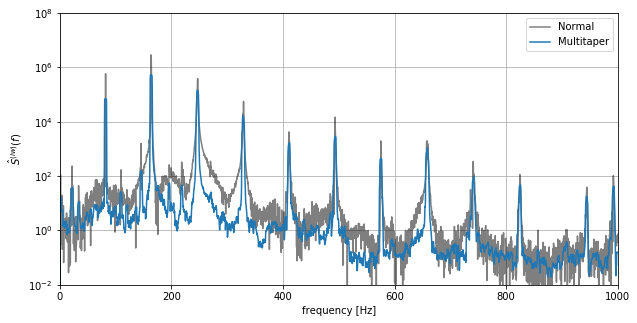

In [174]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E, label='Normal', c='k', alpha=0.5)
ax.semilogy(f_E_multi, Pxx_den_E_multi,label='Multitaper')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel(r'$\hat{S}^{(lw)}(f)$')
ax.set_xlim(0,1000)
ax.set_ylim(10**-2, 10**8) 
ax.legend() 
ax.grid()

plt.show()